# Time Series Forecasting using RNN

In [0]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

### Functions used for processing/preparing the data

In [0]:
def createDelayedColumns(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

def convert3D(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)



## Dataset -  Daily minimum temperatures in Melbourne from 1981 to 1990 

In [6]:
dailyTemps = pd.read_csv("daily-minimum-temperatures.csv", 
                        parse_dates=[0], index_col=[0])
dailyTemps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


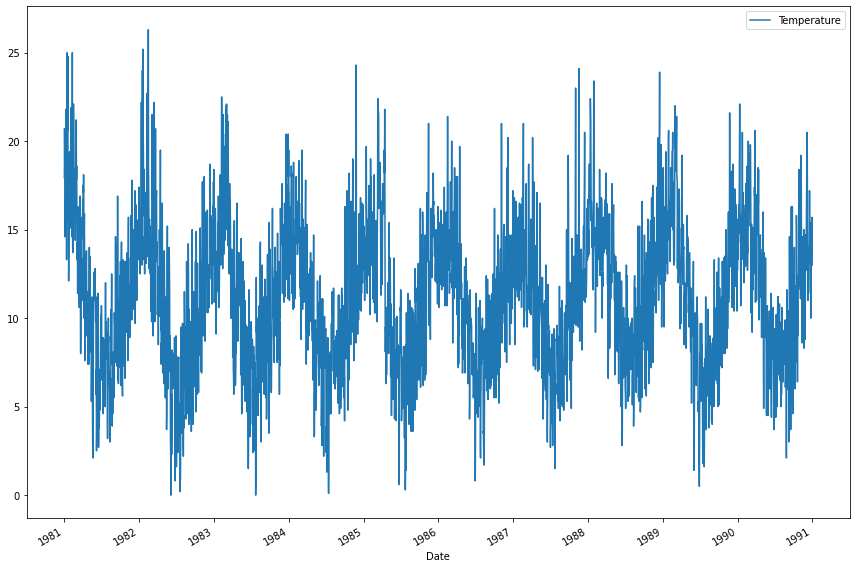

In [7]:
dailyTemps.plot(figsize=(12,8))
plt.tight_layout()
plt.show()

### Based on previous 7 days minimum temperature, predict the minimum temperature after two days

In [8]:
previousDays = 7
afterDays = 2

X = createDelayedColumns(dailyTemps, 
        times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(dailyTemps, 
        times=[afterDays]).iloc[previousDays:-afterDays]

print(X.head())
print(y.head())

print(X.shape)
print(y.shape)

                   t-6         t-5  ...         t-1           t
           Temperature Temperature  ... Temperature Temperature
Date                                ...                        
1981-01-08        17.9        18.8  ...        15.8        17.4
1981-01-09        18.8        14.6  ...        17.4        21.8
1981-01-10        14.6        15.8  ...        21.8        20.0
1981-01-11        15.8        15.8  ...        20.0        16.2
1981-01-12        15.8        15.8  ...        16.2        13.3

[5 rows x 7 columns]
                   t+2
           Temperature
Date                  
1981-01-08        20.0
1981-01-09        16.2
1981-01-10        13.3
1981-01-11        16.7
1981-01-12        21.5
(3641, 7)
(3641, 1)


### Now you have X and y, slice them into training and test dataset.

In [9]:
train_slice = slice(None, '1988-12-28')
test_slice = slice('1989-01-01', None)

Xtrain, Ytrain = X.loc[train_slice], y.loc[train_slice]
Xtest, Ytest = X.loc[test_slice], y.loc[test_slice]

print(Xtrain.shape)
print(Xtest.shape)

(2911, 7)
(728, 7)


### RNN needs 3D input

In [10]:
Xtrain3D = convert3D(Xtrain)
Xtest3D = convert3D(Xtest)

print(Xtrain3D.shape)
print(Xtest3D.shape)

(2911, 7, 1)
(728, 7, 1)


## Vanilla - Simple RNN

In [11]:
rnnModel = keras.models.Sequential()

rnnModel.add(keras.layers.SimpleRNN(50, return_sequences=True,
                                    input_shape=(7,1)))

rnnModel.add(keras.layers.SimpleRNN(25))

rnnModel.add(keras.layers.Dense(1))

rnnModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 7, 50)             2600      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25)                1900      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 4,526
Trainable params: 4,526
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

rnnModel.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [13]:
# train the model

history = rnnModel.fit(Xtrain3D, Ytrain, epochs = 50, batch_size=20, validation_split=0.1, verbose=1 )

Epoch 1/50
131/131 [==============================] - 1s 7ms/step - loss: 35.6372 - mae: 4.8152 - val_loss: 18.2886 - val_mae: 3.3325
Epoch 2/50
131/131 [==============================] - 1s 4ms/step - loss: 17.9960 - mae: 3.3321 - val_loss: 12.1531 - val_mae: 2.7391
Epoch 3/50
131/131 [==============================] - 1s 4ms/step - loss: 12.7142 - mae: 2.7597 - val_loss: 9.7556 - val_mae: 2.4475
Epoch 4/50
131/131 [==============================] - 1s 4ms/step - loss: 10.5908 - mae: 2.5142 - val_loss: 9.4161 - val_mae: 2.4372
Epoch 5/50
131/131 [==============================] - 1s 4ms/step - loss: 9.8713 - mae: 2.4175 - val_loss: 8.6818 - val_mae: 2.3188
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 9.2491 - mae: 2.3465 - val_loss: 8.8923 - val_mae: 2.3697
Epoch 7/50
131/131 [==============================] - 1s 4ms/step - loss: 9.0808 - mae: 2.3374 - val_loss: 8.2886 - val_mae: 2.2678
Epoch 8/50
131/131 [==============================] - 1s 4ms/step - lo

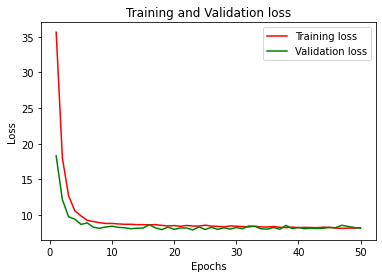

In [14]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [15]:
testResult = rnnModel.evaluate(Xtest3D, Ytest)
print(testResult)

23/23 [==============================] - 0s 2ms/step - loss: 6.9056 - mae: 2.0598
[6.905590057373047, 2.0597753524780273]
